## Getting Started

Need `plotly` version to be 4.6.0 in order for the code to work, try to restart kernel or reset runtime if any error occurs

In [1]:

try:
    import plotly
    if plotly.__version__ == '4.6.0':
        print('Success')
    else:
        print('Upgrading...')
        !pip install plotly --upgrade
except ImportError:
    print('No available module')
    print('Installing...')
    !pip install plotly==4.6.0
    print('Success')
    
!pip install geopandas
!pip install country_converter


Upgrading...
     |████████████████████████████████| 11.5MB 7.5MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


     |████████████████████████████████| 931kB 8.7MB/s 
     |████████████████████████████████| 10.9MB 192kB/s 
     |████████████████████████████████| 14.7MB 326kB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for country-converter: filename=country_converter-0.6.7-cp36-none-any.whl size=50216 sha256=f9dc3b4d987c7c44ee8aba0b8c939f0ea3d558a1ba9a11e970ebf284151961a0
  Stored in directory: /root/.cache/pip/wheels/f9/4a/e7/c8ef69407e41021c414dd56e50bdac424efd1bca3a4346eeb1
Successfully built country-converter


In [1]:
import os
import sys
import re

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import country_converter as coco

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---
## Load Data

In [0]:
# read happiness data into a list of dataframe
base_url = 'https://raw.githubusercontent.com/Benjaminnnnnn/CSE-163-FINAL-PROJECT/master/data'
files = [base_url + '/' + str(i) + '.csv' for i in range(2015, 2020)]

dataframes = [pd.read_csv(file) for file in files]

Let's see if each year's happiness data has the same dataformat (Unfortunately they don't neccesarily have the same column length nor column names) 

In [3]:
print('Length of Each Year\'s Happiness Data')
print([len(df.columns) for df in dataframes])
print()

print('Column Names for Each Year\'s Happiness Data')
print()
for df in dataframes:
    # A peek of the column differences
    print(df.columns.values[0:5])
    print()

Length of Each Year's Happiness Data
[12, 13, 12, 9, 9]

Column Names for Each Year's Happiness Data

['Country' 'Region' 'Happiness Rank' 'Happiness Score' 'Standard Error']

['Country' 'Region' 'Happiness Rank' 'Happiness Score'
 'Lower Confidence Interval']

['Country' 'Happiness.Rank' 'Happiness.Score' 'Whisker.high' 'Whisker.low']

['Overall rank' 'Country or region' 'Score' 'GDP per capita'
 'Social support']

['Overall rank' 'Country or region' 'Score' 'GDP per capita'
 'Social support']



Because they use slightly different column names to record the happiness data, we need to do similar name matching. Besides, there is no `Year` column in any of the dataset. So we want to add a `Year` column for computing the trend of happiness over year.

---
## Data Processing

In [0]:
# add an year column to each year's happiness data
year = 2015
for df in dataframes:
    df['Year'] = year
    year+=1

Compare the data format (column names) between `2015` and `2017`

In [5]:
dataframes[0].head(2)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015


In [6]:
dataframes[2].head(2)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual,Year
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,2017
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,2017


In [7]:
print('Column numbers for each dataset')
print([len(df.columns) for df in dataframes])

Column numbers for each dataset
[13, 14, 13, 10, 10]


In [8]:
dataframes[0]['Year'][0]

2015

Since each year has slightly different style of documenting the happiness scores (i.e. they have different number of columns and column names), we need to make some data transformation that filter out all the columns that we need, and standardize their names by using `re`.

In [0]:
# create the columns to be extracted
# store the regex pattern of column and its full name in
# a pair of tuple, [0] for pattern, [1] for full name

columns = list(map(lambda x: ('(?i).*' + x[0] + '(?i).*', x[1]),
                       [('rank', 'happiness rank'),
                        ('country', 'country'),
                        ('score', 'happiness score'),
                        ('GDP', 'GDP per capita'),
                        ('family', 'family'),
                        ('social', 'family'), # same as "family" but some year use "social support" as the column name
                        ('freedom', 'freedom'),
                        ('health', 'life expectancy'),
                        ('corruption', 'government corruption'), 
                        ('trust', 'government corruption'), # same as "corruption"
                        ('generosity', 'generosity'),
                        ('year', 'year')
                        ])
              )


# using regex to match similar column names
# case-insensitive
column_filter = re.compile('|'.join([col_name[0] for col_name in columns]))

In [0]:
# filtering out all the matching columns
for i, df in enumerate(dataframes):
    all_matches = list(filter(column_filter.match, df.columns))
    dataframes[i] = df[all_matches]

In [0]:
dataframes[0].columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual', 'Year'],
      dtype='object')

In [0]:
dataframes[1].columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Lower Confidence Interval', 'Upper Confidence Interval',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual', 'Year'],
      dtype='object')

In [0]:
dataframes[0].columns

Index(['Country', 'Happiness Rank', 'Happiness Score',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Year'],
      dtype='object')

In [0]:
dataframes[3].columns

Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Year'],
      dtype='object')

In [0]:
[len(df.columns) for df in dataframes]

[10, 10, 10, 10, 10]

Rename all the extracted columns for each dataset and make them consistent

In [0]:
def rename_cols(dataframes, sub_patterns):
    '''
    Rename the columns of the given dataframes to
    the sub_pattern defined.
    
    Parameters:
        - dataframes        - a list of dataframes to be renamed
        - sub_patterns      - a list of tuples consists matching patterns
                              on the first entry, and the replacements on
                              the second entry
        
    Returns:
        - renamed_dfs       - renamed dataframes
    '''
    # col  - column
    # pat  - pattern
    # repl - replacement
    for i, df in enumerate(dataframes):
        new_cols = {}
        for col in df.columns:
            for pat, repl in columns:
                if re.match(pat, col):
                    new_cols[col] = re.sub(pat, repl, col)
        dataframes[i] = df.rename(columns=new_cols)
    return dataframes

In [12]:
dataframes = rename_cols(dataframes, columns)
# check if the rename is correct by peeking one dataframe
dataframes[2].head(1)

,country,happiness rank,happiness score,GDP per capita,family,life expectancy,freedom,generosity,government corruption,year
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2017


In [24]:
l = dataframes[4].columns.tolist()
l.sort()
l

['GDP per capita',
 'country',
 'family',
 'freedom',
 'generosity',
 'government corruption',
 'happiness rank',
 'happiness score',
 'life expectancy',
 'year']

Since all the column names are consistent now, let's concatnate the data for each year into one dataframe

In [0]:
happiness_data = pd.concat(dataframes, ignore_index=True)

In [0]:
happiness_data.shape

(782, 10)

In [0]:
happiness_data.columns.tolist()

['country',
 'happiness rank',
 'happiness score',
 'GDP per capita',
 'family',
 'life expectancy',
 'freedom',
 'government corruption',
 'generosity',
 'year']

In [0]:
print('Null Value in the Dataset')
print(happiness_data.isnull().sum())

Null Value in the Dataset
GDP per capita           0
country                  0
family                   0
freedom                  0
generosity               0
government corruption    1
happiness rank           0
happiness score          0
life expectancy          0
year                     0
dtype: int64


In [0]:
happiness_data.describe()

,GDP per capita,family,freedom,generosity,government corruption,happiness rank,happiness score,life expectancy,year
count,782.000000,782.000000,782.000000,782.000000,781.000000,782.000000,782.000000,782.000000,782.000000
mean,0.916047,1.078392,0.411091,0.218576,0.125436,78.698210,5.379018,0.612416,2016.993606
std,0.407340,0.329548,0.152880,0.122321,0.105816,45.182384,1.127456,0.248309,1.417364
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.693000,0.000000,2015.000000
25%,0.606500,0.869363,0.309768,0.130000,0.054000,40.000000,4.509750,0.440183,2016.000000
50%,0.982205,1.124735,0.431000,0.201982,0.091000,79.000000,5.322000,0.647310,2017.000000
75%,1.236187,1.327250,0.531000,0.278832,0.156030,118.000000,6.189500,0.808000,2018.000000
max,2.096000,1.644000,0.724000,0.838075,0.551910,158.000000,7.769000,1.141000,2019.000000


In [0]:
happiness_data['region'] = coco.convert(happiness_data['country'].to_list(), to='unregion')
happiness_data.head(3)

,country,happiness rank,happiness score,GDP per capita,family,life expectancy,freedom,government corruption,generosity,year,region
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015,Western Europe
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015,Northern Europe
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015,Northern Europe


In [0]:
happiness_data.columns.tolist()
happiness_data['region'][0]

'Western Europe'

## Research Questions
---

### Question 1
What is the distribution of the happiness scores? (I'm just plotting some graphs, and I will choose whichever that is more informative later)

Let's see the distribution of happiness score each year

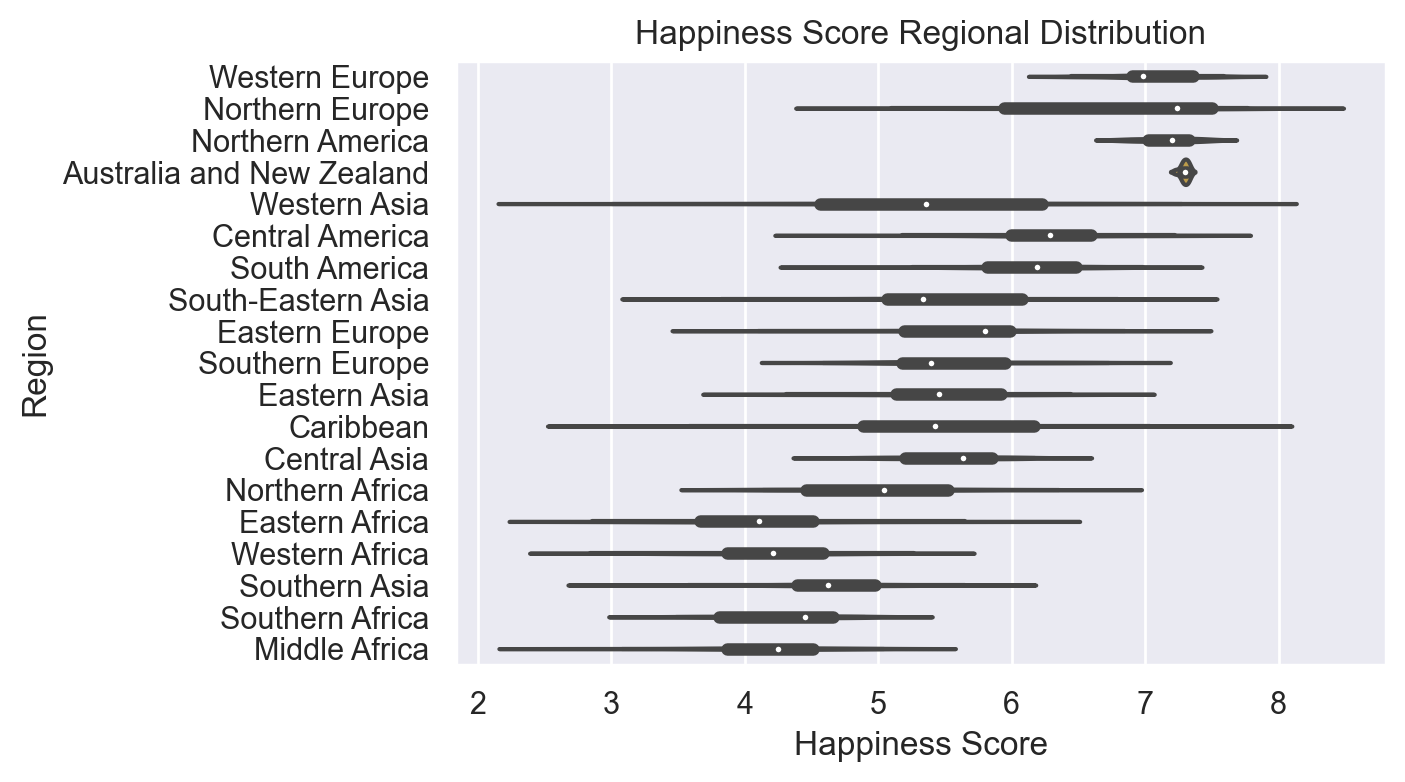

In [0]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax = sns.violinplot(x=happiness_data['happiness score'], 
                    y=happiness_data['region'])
ax.set_xlabel('Happiness Score')
ax.set_ylabel('Region')
ax.set_title('Happiness Score Regional Distribution')
fig.show()

In [0]:
# make subplots for each year's distribution
fig = make_subplots(rows=1, cols=5, shared_yaxes=True, vertical_spacing=0.04)

# getting colors for plotting
color_histogram = px.colors.qualitative.Set1
color_discrete_sequence = px.colors.qualitative.D3

for i, color in list(zip(range(2015, 2020), color_discrete_sequence)):
    data = happiness_data[happiness_data['year']==i]['happiness score']
    mean_score = data.mean()
    
    # add a histogram to the figure
    fig.add_trace(go.Histogram(x=data, 
                               name=i, 
                               hovertemplate='Count %{y}', 
                               text='%{y}', 
                               nbinsx=10,
                               marker_color=color_histogram[i-2015],
                               opacity=0.8), 
                  row=1, col=i-2014)
    # update fig x range
    fig.update_xaxes(nticks=10)
    
    # add a vertical line (mean happiness score) to the figure
    fig.add_trace(go.Scatter(x=[round(mean_score, 2)] * 50, y=np.arange(-1, 40), 
                             line=dict(
                                 color=color_discrete_sequence[2015-i]
                             ), 
                             name=str(i)+' Mean', 
                             showlegend=False, 
                             mode='lines',
                             hovertemplate=round(mean_score, 2)),
                  row=1, col=i-2014)

# update the entire subplots layout
fig.update_layout(height=400, title='Happiness Score Yearly Distribution', 
                  legend_title_text='Year', yaxis=dict(range=[0, 30]),
                  hovermode='x unified')
fig.show()

And let's see some correlation between happiness data

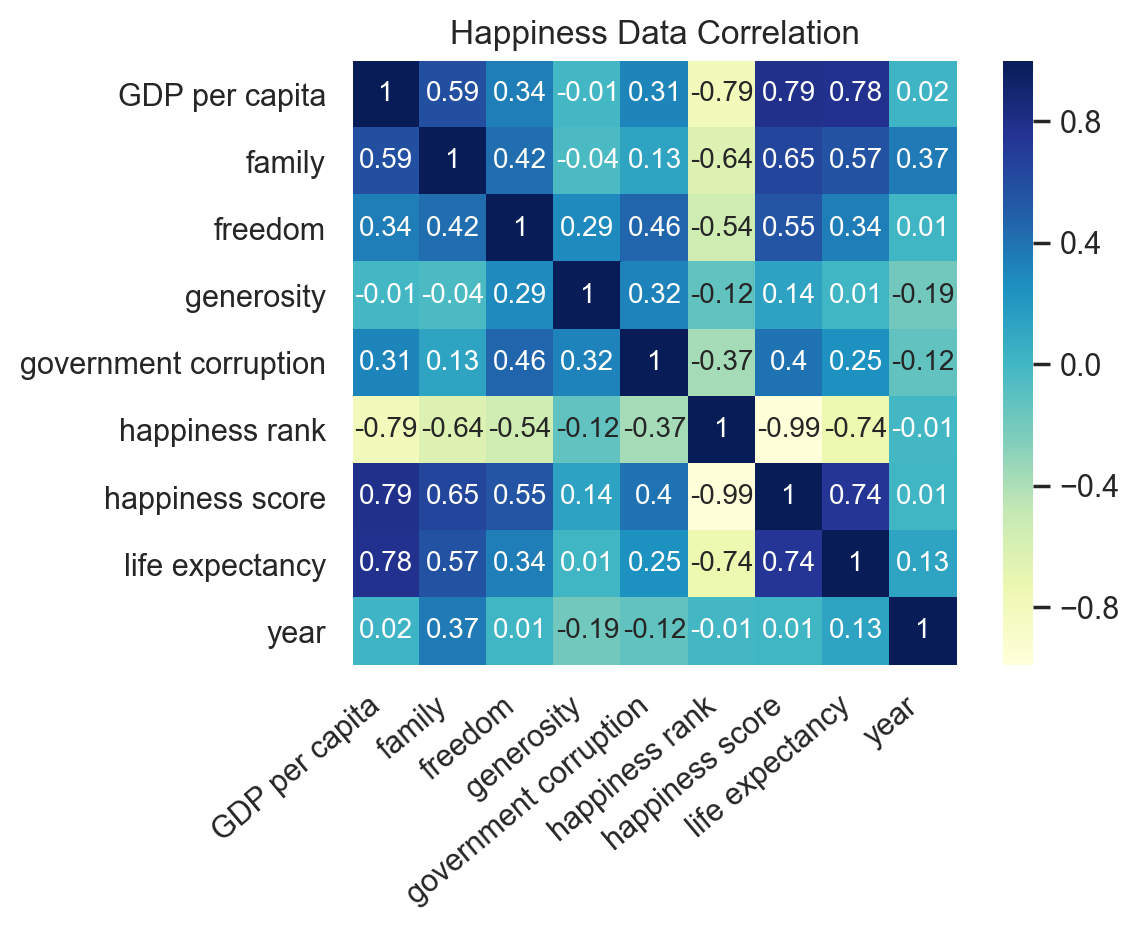

In [0]:
# correlation of each columns with respect another column in the happiness data
corr = happiness_data.corr().apply(lambda x: round(x, 2))

# create high resolution figure
fig, ax = plt.subplots(1, 1, dpi=200)
ax = sns.heatmap(corr, square=True, annot=True, cmap='YlGnBu')

# set the orientation of the x labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=40,
    horizontalalignment='right'
)
ax.set_title('Happiness Data Correlation', fontsize=12)
fig.show()

Now let's project our happiness score to a globe

In [0]:
# create choropleth map data
# locations by country
data = go.Choropleth(locations=happiness_data['country'],
                     locationmode='country names',
                     z=happiness_data['happiness score'],
                     text=happiness_data['country'],
                     colorbar={'title':'Happiness Score'},
                     colorscale=px.colors.sequential.Pinkyl)

# display ocean on the map
# projection is orthographic
# show grid for both lon and lat
layout = go.Layout(title='Happiness Score Distribution',
                   geo=dict(showframe=False,
                            showocean=True,
                            projection={'type':'orthographic'},
                            oceancolor='rgb(0,119,190)',
                            lonaxis=dict(showgrid=True,
                                         gridcolor='rgb(102,102,102)'),
                            lataxis=dict(showgrid=True,
                                         gridcolor='rgb(102,102,102)')))
# plotting
fig = go.Figure(data=data,
                layout=layout)
fig.show()

### Question 2

Which five countries have the most happiness score? Which five countries have the least happiness score? What are the geolocations of these countries?

Since our dataset includes scores from 2015-2019, we will take the average of the countries' happiness scores and see which ones have the highest and which countries have the lowest average happiness scores.

In [0]:
avg_happiness = happiness_data.groupby(['country'])['happiness score'].mean()

After getting their average happiness scores, we obtain 5 countries with the highest happiness scores and the 5 countries with the lowest happiness scores.
The countries with the highest scores are:
*   Denmark
*   Norway
*   Finland
*   Switzerland
*   Iceland

The countries with the lowest scores are:
*   Burundi
*   Central African Republic
*   Syria
*   South Sudan
*   Rwanda

In [0]:
print('Happiest Countries')
print(avg_happiness.nlargest(5))
print('--------------------------------')
print('Least Happy Countries')
print(avg_happiness.nsmallest(5))

Happiest Countries
country
Denmark        7.5460
Norway         7.5410
Finland        7.5378
Switzerland    7.5114
Iceland        7.5110
Name: happiness score, dtype: float64
--------------------------------
Least Happy Countries
country
Burundi                     3.07900
Central African Republic    3.13425
Syria                       3.29220
South Sudan                 3.38250
Rwanda                      3.43860
Name: happiness score, dtype: float64


Before plotting these countries on the world map, we remove Antarctica from the data.

In [0]:
countries = gpd.read_file('https://raw.githubusercontent.com/Benjaminnnnnn/CSE-163-FINAL-PROJECT/master/data/countries.geojson')
countries = countries[countries['ADMIN'] != 'Antarctica']

Now we can plot the 10 countries. Notice that the five happiest countries (`color='pink'`) are all in Western Europe and four out of five least happy countries (`color=purple`) are in Africa.

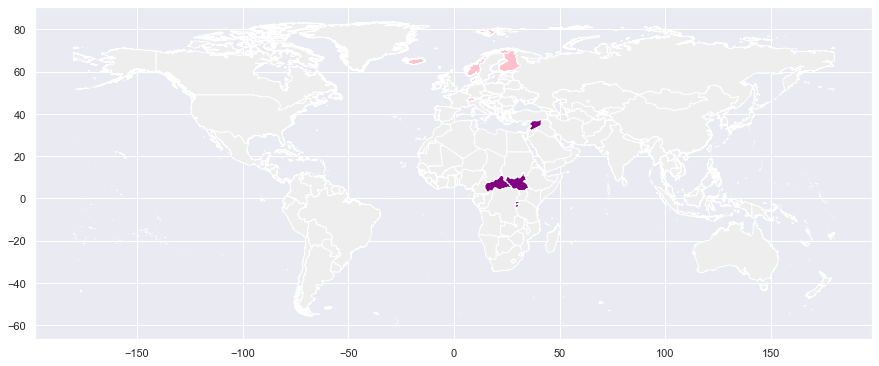

In [0]:
top_5_happy_countries = countries[(countries['ADMIN'] == 'Denmark') |
                                  (countries['ADMIN'] == 'Norway' ) |
                                  (countries['ADMIN'] == 'Finland') |
                                  (countries['ADMIN'] == 'Switzerland') |
                                  (countries['ADMIN'] == 'Iceland')]
top_5_sad_countries = countries[(countries['ADMIN'] == 'Burundi') |
                                (countries['ADMIN'] == 'Central African Republic' ) |
                                (countries['ADMIN'] == 'Syria') |
                                (countries['ADMIN'] == 'South Sudan') |
                                (countries['ADMIN'] == 'Rwanda')]

fig, ax = plt.subplots(1, figsize=(15, 7))
countries.plot(ax=ax, color='#EEEEEE')
top_5_happy_countries.plot(color='pink', ax=ax)
top_5_sad_countries.plot(color='purple', ax=ax)

### Question 3

What are the trends of happiness among different countries? Are they increasing, decreasing, or fluctuating?

First we need to calculate the five happiest/saddest countries:

In [0]:
# Five happiest/saddest countries in 2019
happy_five_2019 = happiness_data[happiness_data['year'] == 2019].nlargest(5, 'happiness score')
happy_five_2019 = happy_five_2019['country'].tolist()

sad_five_2019 = happiness_data[happiness_data['year'] == 2019].nsmallest(5, 'happiness score')
sad_five_2019 = sad_five_2019['country'].tolist()

In [0]:
# Five happiest/saddest countries overall from 2015-2019

# Sort rows based on happiness score, then drop duplicates from country column 
happy_five = happiness_data.sort_values(['happiness score'], ascending=False).drop_duplicates(subset='country').nlargest(5, 'happiness score')
happy_five = happy_five['country'].tolist()

sad_five = happiness_data.sort_values(['happiness score']).drop_duplicates(subset='country').nsmallest(5, 'happiness score')
sad_five = sad_five['country'].tolist()

We can try plotting the trends with seaborn first.

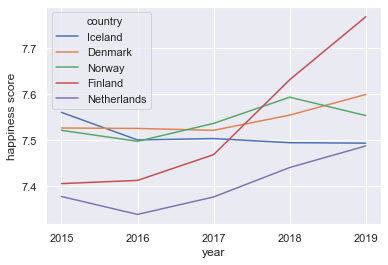

In [0]:
# Plot the trends for the five happiest countries (in 2019)
years = [2015, 2016, 2017, 2018, 2019]
happy_countries = happiness_data[happiness_data['country'].isin(happy_five_2019)]
ax = sns.lineplot(x="year", y="happiness score",
              hue='country', data=happy_countries)
ax.set_xticks(years)

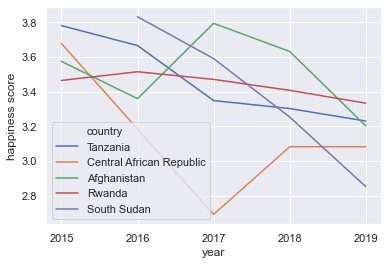

In [0]:
# Plot the trends for the five saddest countries (in 2019)
sad_countries = happiness_data[happiness_data['country'].isin(sad_five_2019)]
ax = sns.lineplot(x="year", y="happiness score",
              hue='country', data=sad_countries)
ax.set_xticks(years)

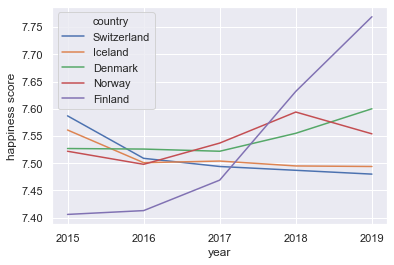

In [0]:
# Plot the trends for the five happiest countries (2015-2019)
happy_overall = happiness_data[happiness_data['country'].isin(happy_five)]
ax = sns.lineplot(x="year", y="happiness score",
              hue='country', data=happy_overall)
ax.set_xticks(years)

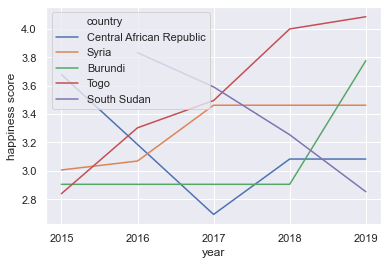

In [0]:
# Plot the trends for the five saddest countries (2015-2019)
sad_overall = happiness_data[happiness_data['country'].isin(sad_five)]
ax = sns.lineplot(x="year", y="happiness score",
              hue='country', data=sad_overall)
ax.set_xticks(years)

We can try plotting the trends again using plotly.graph_objects for different data visualizations.

In [0]:
title = 'Five Happiest Countries: Happiness Over Time'
RdPu = px.colors.sequential.RdPu

colors = [RdPu[2], RdPu[3], RdPu[4], RdPu[6], RdPu[8]] 

fig = go.Figure()
for i in range(5):
  df = happy_overall[(happy_overall['country']) == happy_five[i]]
  fig.add_trace(go.Scatter(x=df['year'], y=df['happiness score'],
                           mode='lines', name=happy_five[i],
                line=dict(color=colors[i])))
  # points
  fig.add_trace(go.Scatter(
      x=df['year'],
      y=df['happiness score'],
      mode='markers',
      marker=dict(color=colors[i]),
      showlegend=False
  ))


fig.update_layout(
    autosize = False,
    height = 600,
    width = 1100,
    showlegend=False,
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 2015,
        dtick = 1,
        showline=True,
        showgrid=False,
        ticks='outside',
        color='grey'
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        color='grey'
    ),
    margin=dict(
        autoexpand=True,
        r=175
    ),
    plot_bgcolor='white'
)

annotations=[]
# Adding labels
for country, color in zip(happy_five, colors):
  df = happy_overall[(happy_overall['country']) == country]
  y_data = df['happiness score'].tolist()

  # labeling the right_side of the plot
  annotations.append(dict(xref='paper', x=0.95, y=y_data[4],
                          xanchor='left', yanchor='middle',
                          text='{0:.2f} '.format(y_data[4]) + country,
                          font=dict(size=16,
                                    color=color),
                          showarrow=False))

# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.0,
                        xanchor='left', yanchor='bottom',
                        text=title, 
                        font=dict(size=30,
                                  color='grey'),
                        showarrow=False))

# Y-axis Label
annotations.append(dict(xref='paper', yref='paper', x=-0.07, y=0.5,
                              xanchor='left', yanchor='middle',
                              text='Happiness Score',
                              textangle=270,
                              font=dict(size=16, color='grey'),
                              showarrow=False))

# X-axis Label
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Years',
                              font=dict(size=16, color='grey'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

In [0]:
sad_overall

,GDP per capita,country,family,freedom,generosity,government corruption,happiness rank,happiness score,life expectancy,year
147,0.078500,Central African Republic,0.000000,0.488790,0.238350,0.082890,148,3.678,0.066990,2015
155,0.663200,Syria,0.474890,0.156840,0.471790,0.189060,156,3.006,0.721930,2015
156,0.015300,Burundi,0.415870,0.118500,0.197270,0.100620,157,2.905,0.223960,2015
157,0.208680,Togo,0.139950,0.364530,0.166810,0.107310,158,2.839,0.284430,2015
300,0.393940,South Sudan,0.185190,0.196620,0.258990,0.130150,143,3.832,0.157810,2016
312,0.281230,Togo,0.000000,0.346780,0.175170,0.115870,155,3.303,0.248110,2016
313,0.747190,Syria,0.148660,0.069120,0.483970,0.172330,156,3.069,0.629940,2016
314,0.068310,Burundi,0.234420,0.043200,0.202900,0.094190,157,2.905,0.157470,2016
461,0.397249,South Sudan,0.601323,0.147062,0.285671,0.116794,147,3.591,0.163486,2017
464,0.305445,Togo,0.431883,0.380426,0.196896,0.095665,150,3.495,0.247106,2017


In [0]:
title = 'Five Saddest Countries: Happiness Over Time'
YGB = px.colors.sequential.YlGnBu
'''
for i in range(0, len(RdPu), 2):
  colors.append(RdPu[i])
'''
colors = [YGB[2], YGB[3], YGB[5], YGB[6], YGB[8]] 

fig = go.Figure()
for i in range(5):
  df = sad_overall[(sad_overall['country']) == sad_five[i]]
  fig.add_trace(go.Scatter(x=df['year'], y=df['happiness score'],
                           mode='lines', name=sad_five[i],
                line=dict(color=colors[i])))
  # points
  fig.add_trace(go.Scatter(
      x=df['year'],
      y=df['happiness score'],
      mode='markers',
      marker=dict(color=colors[i]),
      showlegend=False
  ))

fig.update_layout(
    autosize = False,
    height = 600,
    width = 1100,
    showlegend=False,
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 2015,
        dtick = 1,
        showline=True,
        showgrid=False,
        ticks='outside',
        color='grey'
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        color='grey'
    ),
    margin=dict(
        autoexpand=True,
        r=175
    ),
    plot_bgcolor='white'
)

annotations=[]
# Adding labels
for country, color in zip(sad_five, colors):
  df = sad_overall[(sad_overall['country']) == country]
  y_data = df['happiness score'].tolist()
  '''
  # labeling the left_side of the plot
  annotations.append(dict(xref='paper', x=0.05, y=y_data[0],
                          xanchor='right', yanchor='middle',
                          text='{0:.2f}'.format(y_data[0]),
                          font=dict(size=9, color=color),
                          showarrow=False))
                          '''
  # labeling the right_side of the plot
  annotations.append(dict(xref='paper', x=0.95, y=y_data[len(y_data)-1],
                          xanchor='left', yanchor='middle',
                          text='{0:.2f} '.format(y_data[len(y_data)-1]) + country,
                          font=dict(size=16,
                                    color=color),
                          showarrow=False))

# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.0,
                        xanchor='left', yanchor='bottom',
                        text=title, 
                        font=dict(size=30,
                                  color='grey'),
                        showarrow=False))

# Y-axis Label
annotations.append(dict(xref='paper', yref='paper', x=-0.07, y=0.5,
                              xanchor='left', yanchor='middle',
                              text='Happiness Score',
                              textangle=270,
                              font=dict(size=16, color='grey'),
                              showarrow=False))

# X-axis Label
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Years',
                              font=dict(size=16, color='grey'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

### Question 4

What are some measures that contribute to a higher happiness score? And what are some measures that contribute to a lower happiness score?

For this question, we will set up a decision tree classifier to reveal the important measures to happiness score by determining whether a country will be happy or not given the six key factors(e.g. family support, health, GDP, etc.) and year. The original data is not labeled, and we don't have a very academic definition of **happy** countries. But for simplicity, we will just use the mean happiness score to separate happy and not happy country. In other words:

If $Score(country) < \text{mean happiness score}, Label = -1$

Else $Label = 1$

And then we will use `model._feature_importances` to determine the correlations. 

For model testing, since the data is time series, we will withhold the lastest data from `2019`.

In [0]:
labeled_data = []

for i in range(2015, 2020):
    data = happiness_data[happiness_data['year'] == i].copy()
    mean = data['happiness score'].mean()
    data['label'] = data['happiness score'].apply(lambda x: -1 if x < mean else 1)
    labeled_data.append(data)

labeled_data = pd.concat(labeled_data)
labeled_data.head(2)

,GDP per capita,country,family,freedom,generosity,government corruption,happiness rank,happiness score,life expectancy,year,label
0,1.39651,Switzerland,1.34951,0.66557,0.29678,0.41978,1,7.587,0.94143,2015,1
1,1.30232,Iceland,1.40223,0.62877,0.43630,0.14145,2,7.561,0.94784,2015,1


In [0]:
# split the data, 80:20 percent
train_mask = (labeled_data['year'] >= 2015) & (labeled_data['year'] <= 2018)
test_mask = labeled_data['year'] == 2019

train = labeled_data[train_mask].copy()
test = labeled_data[test_mask].copy()

In [0]:
print('Train Shape:', train.shape)
print()
print('Test Shape:', test.shape)

Train Shape: (626, 11)

Test Shape: (156, 11)


Let's explore how many null values we have in each dataset.

In [0]:
print('Null Values in Training Data')
print(train.isnull().sum())
print()
print('Null Values in Testing Data')
print(test.isnull().sum())

Null Values in Training Data
GDP per capita           0
country                  0
family                   0
freedom                  0
generosity               0
government corruption    1
happiness rank           0
happiness score          0
life expectancy          0
year                     0
label                    0
dtype: int64

Null Values in Testing Data
GDP per capita           0
country                  0
family                   0
freedom                  0
generosity               0
government corruption    0
happiness rank           0
happiness score          0
life expectancy          0
year                     0
label                    0
dtype: int64


Since the proportion of the missing data is extremely small, we can just simply ignore that observation.

In [0]:
train = train.dropna()
test = test.dropna()

In [0]:
# extract features
features = ['GDP per capita',
            'family',
            'freedom',
            'generosity',
            'government corruption',
            'life expectancy',
            'year']

target = 'label'

Let's make a simple `DecisionTreeClassifier`, so we can visualize the model

In [0]:
from sklearn.tree import DecisionTreeClassifier

small_tree_model = DecisionTreeClassifier(max_depth=2)
small_tree_model.fit(train[features], train[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Now let's visualize our `small_tree_model`

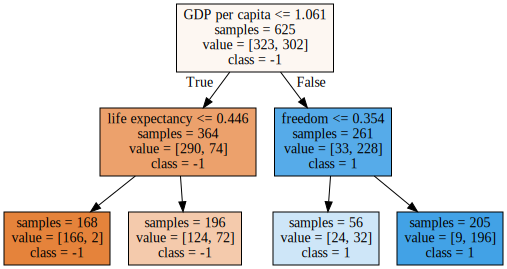

In [0]:
from sklearn import tree
try:
    import graphviz
    def draw_tree(tree_model, features):
        """
        visualizes a Decision Tree
        """
        tree_data = tree.export_graphviz(tree_model, 
                                         impurity=False, 
                                         feature_names=features,
                                         class_names=tree_model.classes_.astype(str),
                                         filled=True,
                                         out_file=None)
        graph = graphviz.Source(tree_data) 
        display(graph)
        
    draw_tree(small_tree_model, features)
except:
    print('You need to download graphviz package')

Using this `small_tree_model`, let's make some predictions on a small sample of testing data.

In [0]:
# using the first six samples of the data labeled 1 and -1
samples = pd.concat([test[test['label'] == 1][0:3], 
                     test[test['label'] == -1][0:3]])

In [0]:
from sklearn.metrics import accuracy_score
print('Testing Accuracy')
print(accuracy_score(y_pred=small_tree_model.predict(samples[features]),
                     y_true=samples[target]))
print()
print('Training Accuracy')
print(accuracy_score(y_pred=small_tree_model.predict(train[features]),
                     y_true=train[target]))

Testing Accuracy
0.6666666666666666

Training Accuracy
0.8288


The accuracy of our `small_tree_model` is apparently underfitting the data, so we need to make a better model to interpret the data. To do this, we use a `GridSearchCV` to find the best hyperparamters.

Since we have a small dataset, we can use `LeaveOneOut` cross validation method here to prevent overfitting our model.

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut


max_depth = [1, 3, 5, 7, 10, 13, 15, 20]
min_samples_leaf = [1, 5, 10, 15, 50, 100, 200]

hyperparameters = {
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf
                  }

clf = GridSearchCV(estimator=DecisionTreeClassifier(),
                   cv=LeaveOneOut(),
                   param_grid=hyperparameters,
                   return_train_score=True)
clf.fit(X=train[features], y=train[target])

GridSearchCV(cv=LeaveOneOut(), error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, 10, 13, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 

In [0]:
# best parameters
print(clf.best_params_)

{'max_depth': 7, 'min_samples_leaf': 15}


In [0]:
print('Testing Accuracy')
print(accuracy_score(y_pred=clf.best_estimator_.predict(test[features]),
                     y_true=test[target]))
print()
print('Training Accuracy')
print(accuracy_score(y_pred=clf.best_estimator_.predict(train[features]),
                     y_true=train[target]))

Testing Accuracy
0.8653846153846154

Training Accuracy
0.9008


In [0]:
def print_feature_importances(model, features):
    '''
    print the importances of given features in the model
    '''
    print('Feature Importance')
    coefficients = list(zip(features, model.feature_importances_))
    print(*coefficients, sep='\n')

In [0]:
# print the importance of each measure
print_feature_importances(clf.best_estimator_, features)

Feature Importance
('GDP per capita', 0.6435030400565376)
('family', 0.048942505067716066)
('freedom', 0.15160291791753402)
('generosity', 0.04807254533556081)
('government corruption', 0.0)
('life expectancy', 0.10787899162265155)
('year', 0.0)


In [0]:
def plot_scores(clf, hyperparameters, score_key, name, showscale):
    cv_results = clf.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape(len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf']))
    max_depth = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    return go.Surface(x=max_depth, y=min_samples_leaf, z=scores, 
                      showscale=showscale, colorscale='YlGnBu', name=name)

In [0]:
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=['Train Accuracy', 'Test Accuracy'],
                    specs=[[{'type':'surface'},
                            {'type':'surface'}]])
fig.add_trace(plot_scores(clf, hyperparameters, 'mean_train_score', 'Train', True), row=1, col=1)
fig.add_trace(plot_scores(clf, hyperparameters, 'mean_test_score', 'Test', False), row=1, col=2)

# update x axis title and y axis title for both subplots
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='Max Depth'
        ),
        yaxis=dict(
            title='Min Samples Leaf'
        ),
        zaxis=dict(
            title='Accuracy'
        ),
        camera_eye=dict(
            x=-2, y=-2, z= 0.8
        )
    ), 
    scene2=dict(
        xaxis=dict(
            title='Max Depth'
        ),
        yaxis=dict(
            title='Min Samples Leaf'
        ),
        zaxis=dict(
            title='Accuracy'
        ),
        camera_eye=dict(
            x=-2, y=-2, z= 0.8
        )
    )
)

fig.show()

The next test accuracy plot looks really bad.

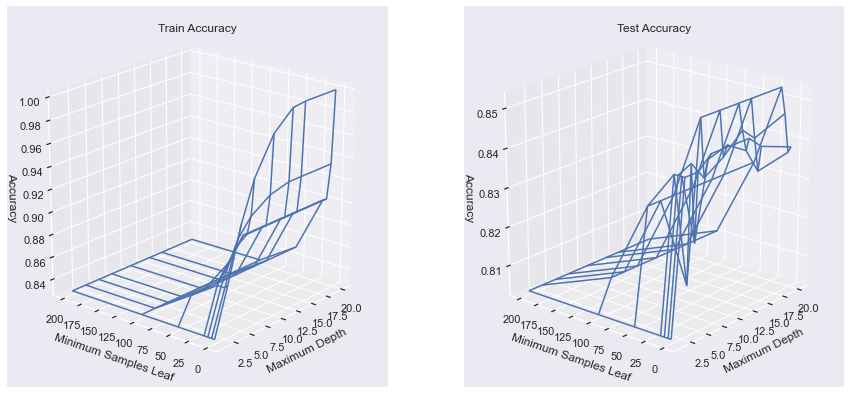

In [0]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', clf, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Test Accuracy', clf, hyperparameters, 'mean_test_score')